# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 2</span>


### Exercise 02.1
- Compute the following 1D integral via Monte Carlo 
$$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$

1. sampling a uniform distribution in $[0,1]$
2. using importance sampling (i.e. sampling a non-uniform probability in $[0,1]$)

<span style="color:red">Show a picture of both your estimations of $I$</span> and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$</font>.

### Solution:

The function:

$$f(x) = \frac{\pi}{2} \cos{\left( \frac{\pi}{2} x \right)}$$

is a periodic function of period $4$. Being a cosine, the first quarter of its cycle ($x \in (0,1)$) has the function being motonically decreasing from $\pi/2$ to 0. A smart choice for a sampling distribution would be the Taylor expansion of $f$ around $0$, truncated at the second order.

$$\cos(x) \approx 1 - \frac{x^2}{2}$$

$$\int_0^1 1 - \frac 1 2 \left(\frac \pi 2 x \right)^2 \, \text d x = \left. x - \frac 1 2 \left(\frac \pi 2 \right)^2 \, \frac{x^3}{3} \right|_{\,0}^{\,1} = 1 - \frac{\pi^2}{24}$$

My sampling distribution will therefore be:

$$p(x) = \frac{1 - \frac{\pi^2}{8} x^2}{1 - \frac{\pi^2}{24}}$$

and I will sample:

$$g(x) = \frac{f(x)}{p(x)} = \frac{\pi}{2} \left( 1 - \frac{\pi^2}{24} \right) \frac{\cos{\left( \frac{\pi}{2} x \right)}}{1 - \frac{\pi^2}{8} x^2} $$

I can use inversion sampling to generate pseudo-random numbers from $p(x)$. First I need to compute the cumulative distribution:

$$P(x) = \int_0^x p(y) \, \text d y = \frac{x - \frac{\pi^2}{24} x^3}{1 - \frac{\pi^2}{24}} = \frac{\frac{24}{\pi^2}x - x^3}{\frac{24}{\pi^2} - 1} $$

which is invertible between $0$ and $1$. Using Cardano's formula:

$$P^{-1} (y) = \sqrt[\leftroot{3}\uproot{4}\scriptstyle 3]{- \frac{D y}{2} + \sqrt{\frac{D^2 y^2}{4} - \frac{512}{\pi^6}}} + \sqrt[\leftroot{5}\uproot{4}\scriptstyle 3]{- \frac{D y}{2} - \sqrt{\frac{D^2 y^2}{4} - \frac{512}{\pi^6}}} $$

where I wrote $D = \frac{24}{\pi^2} - 1$, which is the denominator of the cumulative distribution, and $y \in (0, 1)$. Now there's one more little problem to deal with: $D$ is a real number around $1.43$, which means $D^2 y^2/4$ can never be greater than (more or less) $0.512$. However, this means that the square roots in the above formula have negative arguments ($512/\pi^6 \approx 0.533$)! Keep Calm: Cardano's formula can be extended to work with complex numbers, by extending the square and cubic roots to be complex roots.

The numbers inside the cubic roots are the complex conjugate of each another, as the square roots are imaginary and the remaining part is real. We are trying to compute:

$$\sqrt[3]{a + ib} + \sqrt[3]{a - ib}$$

Now, there are $3$ cubic roots for any given complex number: the absoulte value of the root (which is the same for all three roots) is given by the cubic root of the absolute value, while the three possible arguments are: a third of the original argument, a third of the original argument + $2 \pi /3$, a third of the original argument + $4 \pi /3$. Given that we have to choose the same cubic root for both addenda, the imaginary part is always going to cancel out, and the final result is:

$$ 2 \cdot \Re{\sqrt[3]{a + ib}} = 2 \cdot \sqrt[6]{a^2 + b^2} \cdot \cos \theta$$

where $\theta$ is one of the three possible arguments $\left( \frac 1 3 \arctan{\frac b a} + \frac \pi 3; \frac 1 3 \arctan{\frac b a} + \frac \pi 3 + \frac{2 \pi}{3} ; \frac 1 3 \arctan{\frac b a} + \frac \pi 3 + \frac{4 \pi}{3} \right)$.

$$P^{-1} (y) = 2 \cdot \sqrt[\leftroot{3}\uproot{4}\scriptstyle 6]{\frac{D^2 y^2}{4} + \frac{512}{\pi^6} - \frac{D^2 y^2}{4}} \cdot \cos{\left( \frac 1 3 \arctan{\frac{\sqrt{\frac{512}{\pi^6} - \frac{D^2 y^2}{4}}}{- \frac{D y}{2}}} + (2n+1) \frac{\pi}{3} \right)}$$

with $n \in \{0, 1, 2\}$. Notice that, because $512 = 2^{9}$, the sixth root is actually just $2\sqrt{2}/\pi$. We can also use the fact that the arctangent is odd (and cosine is even) to remove the minus sign from the denominator and rewrite everything as:

$$P^{-1} (y) = \frac{4 \sqrt 2}{\pi} \cos{\left( \frac 1 3 \arctan{\sqrt{\frac{2048}{D^2 y^2 \pi^6} - 1}} - (2n+1) \frac{\pi}{3}\right)}$$

now the only thing left to do is to find the correct value of $n$: to do so I simply computed $P^{-1} (0)$ and $P^{-1} (1)$ for each value of $n$. I found that, while $n=0$ and $n=1$ produce values outside the range $(0,1)$, $n=2$ produces values close to the boundaries of the specified range.

I'm so sorry this took so long but I promise it was so much fun it was worth it.

I then computed the integral $I$ using Monte Carlo, first using the pseudo-random number generator, which samples from a uniform distribution, then using importance sampling with the formula I just derived. I used the same number of blocks ($1000$) and the same blocksize ($1000$) as in the previous lesson:

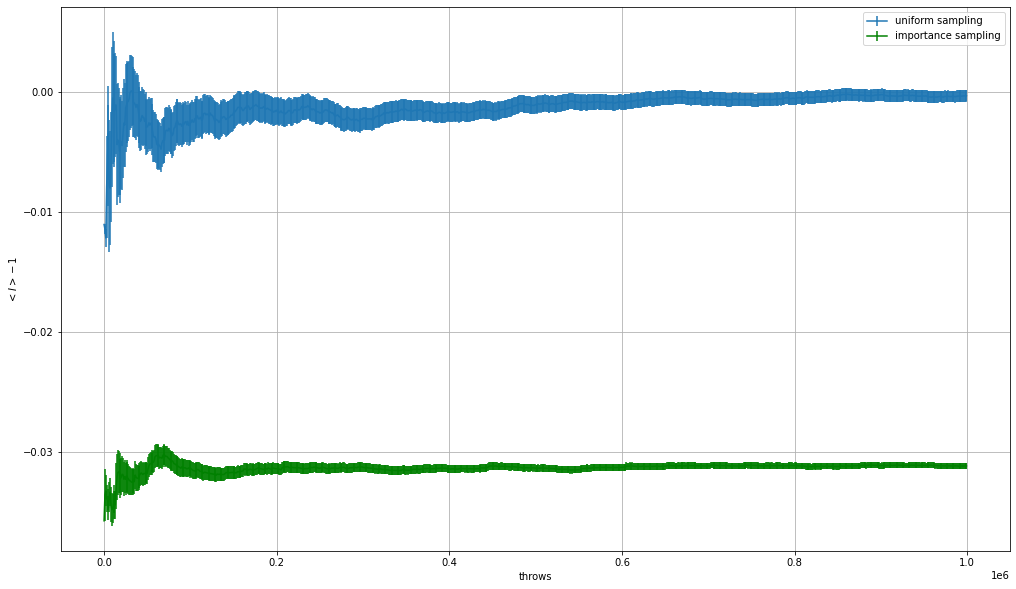

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd 

df = pd.read_csv('output.dat', delimiter='\t', header=None, names=['Uniform', 'Usigma', 'Importance', 'Isigma'])

#print(df)

N=len(df['Uniform'])
L=1000
x = np.arange(N)      # [0,1,2,...,N-1]
    
x*=L # Number of throws = block * (Number of throws in each block)
plt.figure(figsize=(17,10))
plt.errorbar(x,df['Uniform']-1,yerr=df['Usigma'],label='uniform sampling')
plt.errorbar(x,df['Importance']-1,yerr=df['Isigma'],color='green',label='importance sampling')
plt.xlabel('throws')
plt.ylabel('$<I> - 1$')
plt.grid(True)
plt.legend()
plt.show()

We can see that the uniform sampling approach correctly computes the integral. The importance sampling approach has, as expected, a lower statistical uncertainty, but we can appreciate a significant systematical error, that results in an underestimation of the value of $I$ by about $3$%. This error is probably due to numerical errors, caused most likely by the complexity of the ICDF formula.

### Exercise 02.2
- <span style="color:red">3D Random Walks (RW) on a cubic lattice and in the continuum:</span> Repeat many times (e.g. say $10^4$) the simulation of a random walk in 3D always starting at the origin

1. on a cubic lattice with lattice constant $a=1$; at each discrete time the walker makes a forward or backward step of length equal to $a$ in one of the 3 principal directions of the lattice: $x$, $y$ or $z$
2. in the continuum; at each discrete time the walker makes a step of length equal to $a(=1)$ along a **random direction** obtained by sampling **uniformly** the solid angle: $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$

<span style="color:red">Show a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ for both RWs</span>, with their statistical uncertainties, as function of the step $i\in [0,10^2]$.

Suggestion: divide your $M$ throws into a reasonable number of blocks, compute $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ as function of the step $i\in [0,10^2]$ in each block and use these values (for fixed $i$) to obtain the average value and its statistical uncertainty.

Note that you could try to fit both results with a function like $f(N)=k\sqrt{N}$. Do your results indicate a diffusive behavior?

### Solution:

I computed 1 million discrete random walks and 1 million continuous random walks, all of them $100$ steps long. I used the block average method (with the usual 1000 blocks of size 1000) to compute the average distance from the origin (displacement) after each step.

To do so, I computed the average of the square modulus of the position vector and then took the squared root of the average. The statistical uncertainty obtained by block averaging is referred to the square modulus, and to compute the correct one I used error propagation:

$$\sigma = \sqrt{\left(\frac{\partial \sqrt{x}}{\partial x}\right)^2 \sigma_x^2} = \frac{\sigma_x}{2\sqrt{x}}$$

Here's the results after $2$, $10$ and $100$ steps:

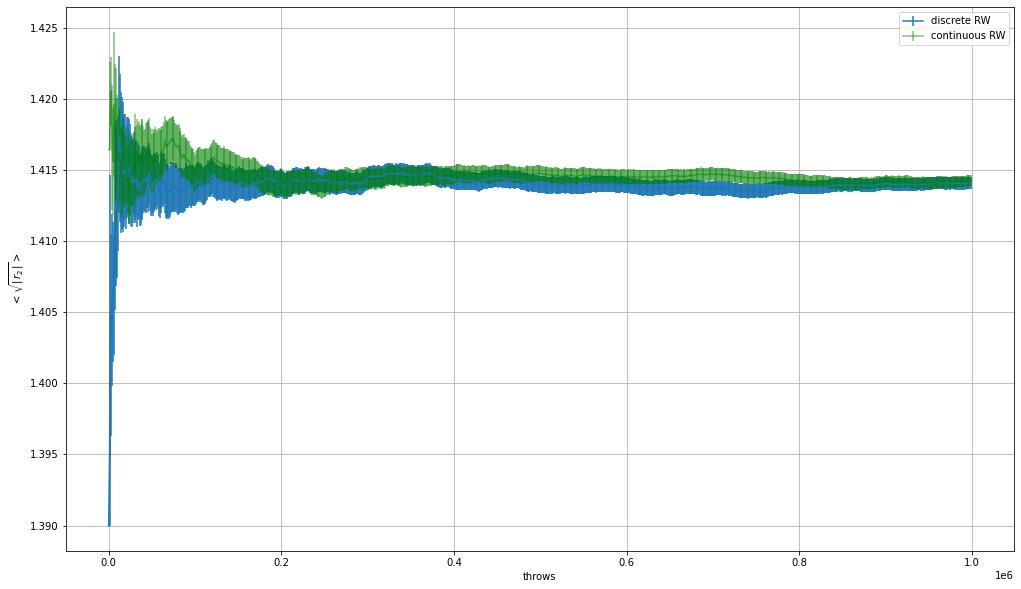

In [11]:
discrete_rw = pd.read_csv('discrete_output.dat', delimiter='\t', header=None, names=['i', 'module', 'sigma'])
continuous_rw = pd.read_csv('continuous_output.dat', delimiter='\t', header=None, names=['i', 'module', 'sigma'])

#print(discrete_rw)

d_indexes = discrete_rw.i.unique()
c_indexes = continuous_rw.i.unique()

#create a data frame dictionary to store data frames
DRW = {elem : pd.DataFrame() for elem in d_indexes}
CRW = {elem : pd.DataFrame() for elem in c_indexes}

for key in DRW.keys():
    DRW[key] = discrete_rw[:][discrete_rw.i == key]
    
for key in CRW.keys():
    CRW[key] = continuous_rw[:][continuous_rw.i == key]
    
#print(CRW[99])

N=len(DRW[1]['module'])
L=1000
x = np.arange(N)      # [0,1,2,...,N-1]
    
x*=L # Number of throws = block * (Number of throws in each block)
plt.figure(figsize=(17,10))
plt.errorbar(x,DRW[1]['module'],yerr=DRW[1]['sigma'],label='discrete RW')
plt.errorbar(x,CRW[1]['module'],yerr=CRW[1]['sigma'],label='continuous RW',color='green',alpha=0.5)
plt.xlabel('throws')
plt.ylabel('$<\sqrt{|\,r_2\,|}>$')
plt.grid(True)
plt.legend()
plt.show()

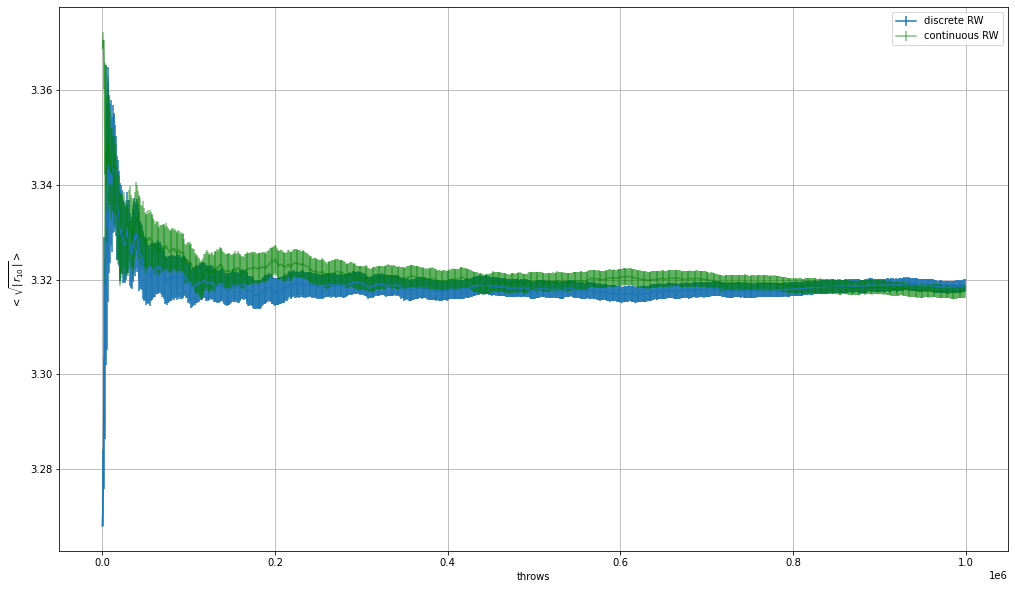

In [3]:
plt.figure(figsize=(17,10))
plt.errorbar(x,DRW[9]['module'],yerr=DRW[9]['sigma'],label='discrete RW')
plt.errorbar(x,CRW[9]['module'],yerr=CRW[9]['sigma'],label='continuous RW',color='green',alpha=0.5)
plt.xlabel('throws')
plt.ylabel('$<\sqrt{|\,r_{10}\,|}>$')
plt.grid(True)
plt.legend()
plt.show()

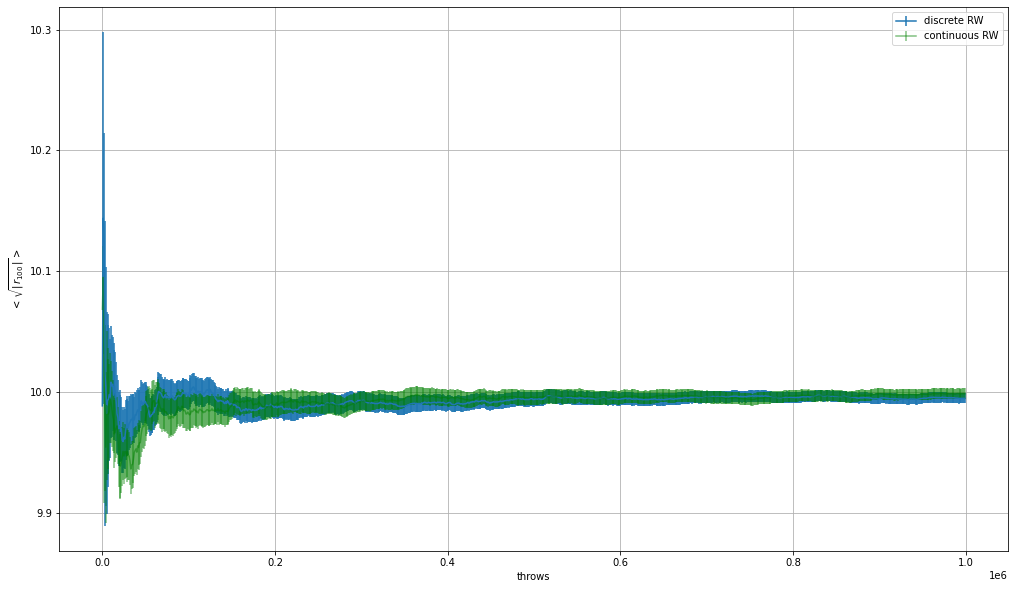

In [12]:
plt.figure(figsize=(17,10))
plt.errorbar(x,DRW[99]['module'],yerr=DRW[99]['sigma'],label='discrete RW')
plt.errorbar(x,CRW[99]['module'],yerr=CRW[99]['sigma'],label='continuous RW',color='green',alpha=0.5)
plt.xlabel('throws')
plt.ylabel('$<\sqrt{|\,r_{100}\,|}>$')
plt.grid(True)
plt.legend()
plt.show()

From these three pictures is clear that the discrete and continuous random walks tend to have very similar behaviours, and the average distance from the origin is pretty much the same in both cases (regardless of the number of steps). I then focused on the behaviour of the average displacement as a function of the number of steps.

In [5]:
def f(n, k):
    return k*np.sqrt(n)

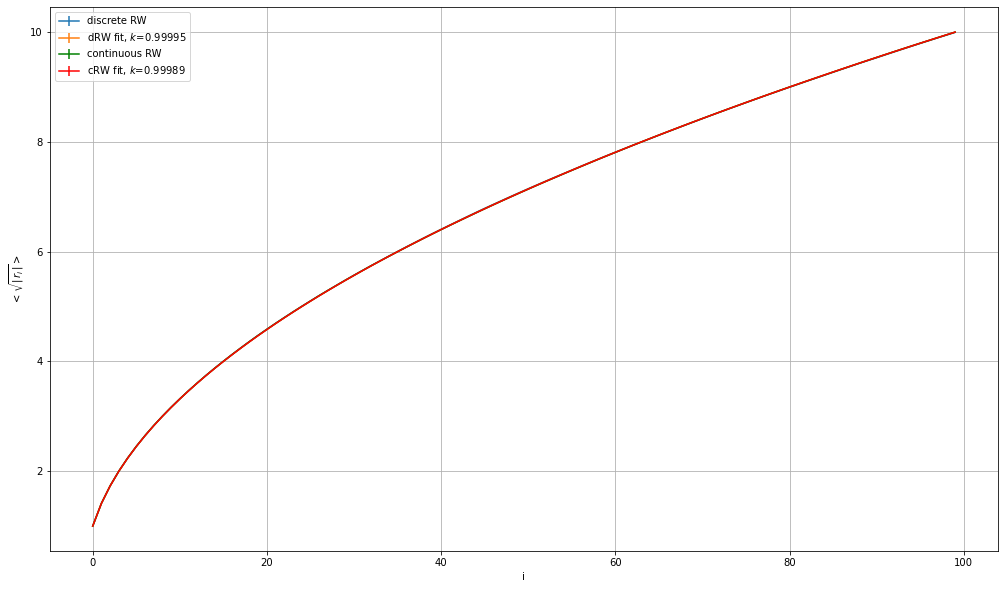

In [19]:
from scipy.optimize import curve_fit

temp_list = []
for key in DRW.keys():
    slave = DRW[key].iloc[-1:]
    temp_list.append(slave)
ADRW = pd.concat(temp_list) #Average Discrete Random Walk

#print(ADRW)

temp_list = []
for key in CRW.keys():
    slave = CRW[key].iloc[-1:]
    temp_list.append(slave)
ACRW = pd.concat(temp_list) #Average Continuous Random Walk

#print(ACRW)

x = np.arange(100) #number of steps
kfit, kcov = curve_fit(f, (ADRW['i']+1).tolist(), ADRW['module'].tolist())
kfit = kfit[0]
cfit, ccov = curve_fit(f, (ACRW['i']+1).tolist(), ACRW['module'].tolist())
cfit = cfit[0]

plt.figure(figsize=(17,10))
plt.errorbar(x,ADRW['module'],yerr=ADRW['sigma'],label='discrete RW')
plt.errorbar(x,f(x+1, kfit),yerr=0,label=r'dRW fit, $k$=' + f'{kfit:.5f}')
plt.errorbar(x,ACRW['module'],yerr=ACRW['sigma'],label='continuous RW',color='green')
plt.errorbar(x,f(x+1, cfit),yerr=0,label=r'cRW fit, $k$=' + f'{cfit:.5f}',color='red',alpha=1)
plt.xlabel('i')
plt.ylabel('$<\sqrt{|\,r_{i}\,|}>$')
plt.grid(True)
plt.legend()
plt.show()

Here's a picture of the average displacement as a function of the number of steps $i$, for both the discrete and continuous case, together with the statistical uncertainties. I also fitted the function $f(n) = k\sqrt{n}$ to both curves, and in both cases I got a value of $k$ very close to 1. 

The 4 curves are poorly distinguishable from each other because they are all very close to each other, and the statistical uncertainties are relatively small.

In both cases, the process shows a diffusive behaviour, as the mean squared displacement grows linearly with the number of steps.